# text feature transformation with topic models 

In [1]:
%matplotlib inline
from ris import ris
import seaborn
import matplotlib.pyplot as plt

In [2]:
with open('data/TrainingData_20170426.ris') as f:
    lines = f.readlines()
    ris = ris.read_ris_lines(lines)

In [3]:
def concat_list_(values):
    if type(values) is list:
        return ','.join(values).decode('ascii', 'ignore')
    else:
        return ''
ris['N2_unwrapped'] = ris.N2.map(concat_list_)

# sparse abstract encoding & LDA fitting

In [4]:
import sklearn.feature_extraction
counter = sklearn.feature_extraction.text.CountVectorizer(max_features=2*4096, stop_words='english')
X = counter.fit_transform(ris['N2_unwrapped'])
X

<28439x8192 sparse matrix of type '<type 'numpy.int64'>'
	with 2867071 stored elements in Compressed Sparse Row format>

In [5]:
import sklearn.decomposition
lda = sklearn.decomposition.LatentDirichletAllocation(n_topics=10)
lda.fit(X)

/home/thread/venvtf/local/lib/python2.7/site-packages/sklearn/decomposition/online_lda.py:508: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)


LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7, learning_method=None,
             learning_offset=10.0, max_doc_update_iter=100, max_iter=10,
             mean_change_tol=0.001, n_jobs=1, n_topics=10, perp_tol=0.1,
             random_state=None, topic_word_prior=None,
             total_samples=1000000.0, verbose=0)

## LDA topics most weighted words

In [6]:
feature_names = counter.get_feature_names()
n_top_words = 15
for topic_idx, topic in enumerate(lda.components_):
    print("Topic #%d:" % topic_idx)
    print(" ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]))


Topic #0:
patients treatment months mg arm chemotherapy survival response median group dose toxicity grade study progression
Topic #1:
group patients surgery postoperative groups vs complications rate compared study results significantly randomized time difference
Topic #2:
studies review cancer trials evidence data treatment literature clinical systematic search included quality articles medline
Topic #3:
95 cancer ci risk studies analysis meta rr associated association results breast confidence pooled study
Topic #4:
cancer prostate levels group pain study serum patients placebo control bone oral significant vitamin significantly
Topic #5:
hcc hpv carcinoma cervical liver patients women group infection hepatocellular tace control rfa dna screening
Topic #6:
patients ct sensitivity diagnostic biopsy pet specificity detection diagnosis imaging lesions thyroid results accuracy study
Topic #7:
cancer patients life quality breast treatment intervention women study qol group symptoms pain 

In [7]:
lda_transformed = lda.transform(X)

# per-sample topic distributions

the sample-topic matrix $M$ stores the relative weighting of topic $j$ in article $i$ in $M_{i\,j}$ where $i$ is the row index and $j$ the column index.

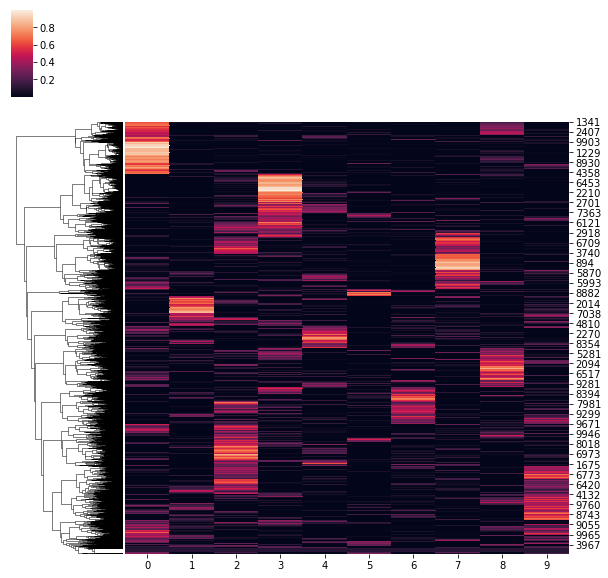

In [8]:
plt.figure(figsize=(12,8))
seaborn.clustermap(lda_transformed[0:10000,:], col_cluster=False)

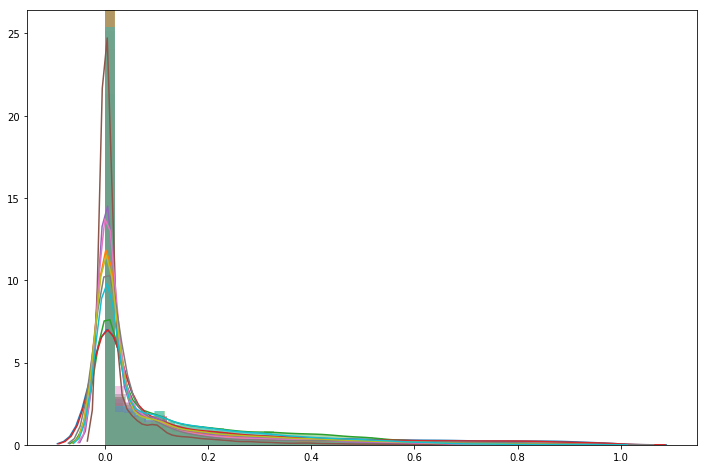

In [20]:
plt.figure(figsize=(12,8))
for i in range(lda_transformed.shape[1]):
    seaborn.distplot(lda_transformed[:,i])

# projection of LDA topics for visualization

In [9]:
import sklearn.manifold
tsne = sklearn.manifold.TSNE(n_components=3)
lda_components_projected = tsne.fit_transform(lda.components_)

In [10]:
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

topic_descriptions = []
for words in [",".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]) for topic in lda.components_]:
    topic_descriptions.append('{}'.format(words))


trace1 = go.Scatter3d(
    x=lda_components_projected[:,0],
    y=lda_components_projected[:,1],
    z=lda_components_projected[:,2],
    text=topic_descriptions,
    mode='markers',
    marker=dict(
        sizemode='diameter',
#         color = topic_average_ratings,
        colorscale = 'Portland',
#         colorbar = dict(title = 'avg. rating'),
        line=dict(color='rgb(255, 255, 255)'),
        opacity=0.75
    )
)

data=[trace1]
layout=dict(height=800, width=800, title='projected LDA topics')
fig=dict(data=data, layout=layout)
py.iplot(fig, filename='3DBubble')

# follow up ideas:

* per LDA topic:
  * compute distribution of tags
  * usefulness fraction
